## Repaso para series de tiempo

In [168]:
import pandas as pd  
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import variation, boxcox, yeojohnson, linregress, chi2 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.model_selection import TimeSeriesSplit 
from statsmodels.tsa.stattools import grangercausalitytests 
from statsmodels.stats.diagnostic import acorr_ljungbox

### Serie a observar

In [169]:
data=pd.read_parquet('df_consol.parquet', engine='pyarrow').reset_index() 

In [170]:
data=data.set_index('FECHA').sort_index() 

## EDA se debe hacer en base al train, nada de test

In [171]:
df_train=data.iloc[:-300]
df_test=data.iloc[-300:] 

In [172]:
df_test

,petroleo_brent,oro,cobre,gas_natural,plata,shanghai,dxy_fut,emergentes,ftse,dax,...,desempleo_mex,produccion_petroleo_usa,produccion_gas_usa,dinero_circulante_eeuu_m2_aprox_lcu,dinero_circulante_china_m2_aprox_lcu,dinero_circulante_japon_m2_aprox_lcu,dinero_circulante_reino_unido_m2_aprox_lcu,dinero_circulante_india_m2_aprox_lcu,dinero_circulante_brasil_m2_aprox_lcu,dinero_circulante_mexico_m2_aprox_lcu
FECHA,,,,,,,,,,,,,,,,,,,,,
2024-09-05,72.690002,2511.399902,4.0775,2.254,28.719999,2788.313965,101.073997,41.451855,8241.700195,18576.500000,...,2.773624,13200.0,3180533.0,2.722883e+13,2.342580e+14,1.557950e+15,3.783015e+12,1.937394e+14,9.324470e+12,1.147430e+13
2024-09-06,71.059998,2493.500000,4.0145,2.275,27.808001,2765.806885,101.142998,40.692162,8181.500000,18301.900391,...,2.773624,13200.0,3180533.0,2.722883e+13,2.342580e+14,1.557950e+15,3.783015e+12,1.937394e+14,9.324470e+12,1.147430e+13
2024-09-09,71.839996,2501.800049,4.0845,2.170,28.291000,2736.488037,101.517998,41.033054,8270.799805,18443.560547,...,2.773624,13200.0,3180533.0,2.722883e+13,2.342580e+14,1.557950e+15,3.783015e+12,1.937394e+14,9.324470e+12,1.147430e+13
2024-09-10,69.190002,2512.300049,4.0405,2.232,28.257000,2744.191895,101.598000,40.877216,8206.000000,18265.919922,...,2.773624,13200.0,3180533.0,2.722883e+13,2.342580e+14,1.557950e+15,3.783015e+12,1.937394e+14,9.324470e+12,1.147430e+13
2024-09-11,70.610001,2512.100098,4.0830,2.270,28.563000,2721.794922,101.657997,41.179146,8193.900391,18330.269531,...,2.773624,13200.0,3180533.0,2.722883e+13,2.342580e+14,1.557950e+15,3.783015e+12,1.937394e+14,9.324470e+12,1.147430e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-23,65.989998,4125.500000,5.0820,3.344,48.481998,3922.409912,98.728996,54.740002,9578.599609,24207.789062,...,2.680840,13500.0,3089788.0,2.722883e+13,3.069129e+14,1.629897e+15,4.103125e+12,1.937394e+14,1.371041e+13,1.556054e+13
2025-10-24,65.940002,4118.399902,5.0935,3.304,48.376999,3950.312012,98.747002,55.099998,9645.599609,24239.890625,...,2.680840,13500.0,3089788.0,2.722883e+13,3.069129e+14,1.629897e+15,4.103125e+12,1.937394e+14,1.371041e+13,1.556054e+13
2025-10-27,65.620003,4001.899902,5.1405,3.442,46.562000,3996.945068,98.563004,55.709999,9653.799805,24308.779297,...,2.680840,13500.0,3089788.0,2.722883e+13,3.069129e+14,1.629897e+15,4.103125e+12,1.937394e+14,1.371041e+13,1.556054e+13


## excluir parte de validacion

In [173]:
y_train=df_train[['oro']].iloc[:-120]

## Descomposición - Aditiva o Multiplicativa

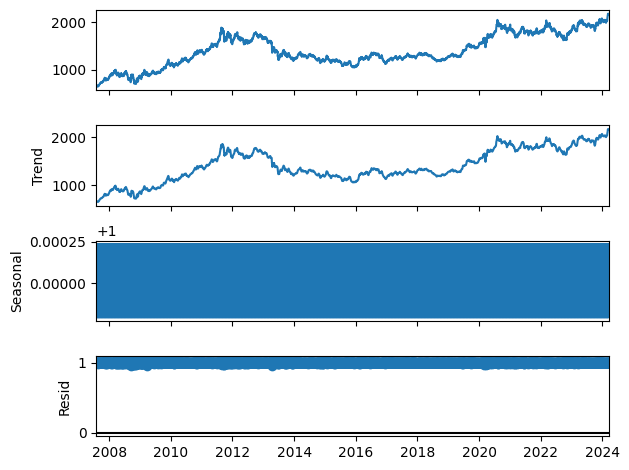

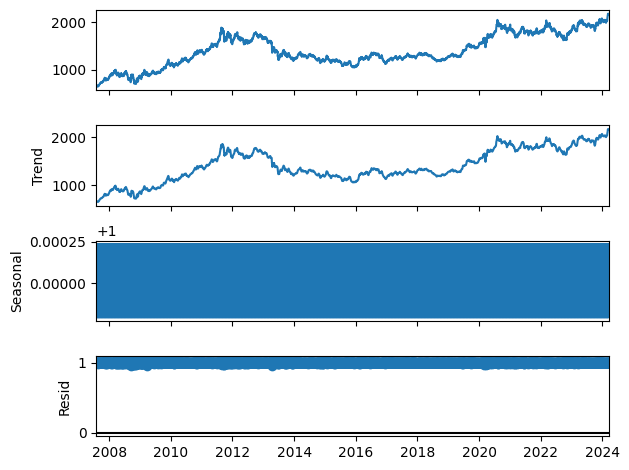

In [174]:
#statsmodels para descomposicion
y = y_train.asfreq("B")          
y = y_train.ffill()              
res_multiplicativa = seasonal_decompose(y_train, model="multiplicative", period=5)
var_mul = np.nanvar(res_multiplicativa.resid) 
res_multiplicativa.plot() 

In [175]:
transformacion, lambda_opt = yeojohnson(y_train['oro'])
print(f"Lambda óptimo: {lambda_opt:.4f}")  
y_train['oro_yj'] = yeojohnson(y_train['oro'], lmbda=lambda_opt) 

Lambda óptimo: 0.7366


In [176]:
y_train.drop(columns=['oro'], inplace=True)

In [177]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="BIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value 
    plt.bar(dfoutput.index[4:], dfoutput.values[4:])
    plt.title("Valores Críticos - ADF Test")
    plt.show()
    return dfoutput

Results of Dickey-Fuller Test:


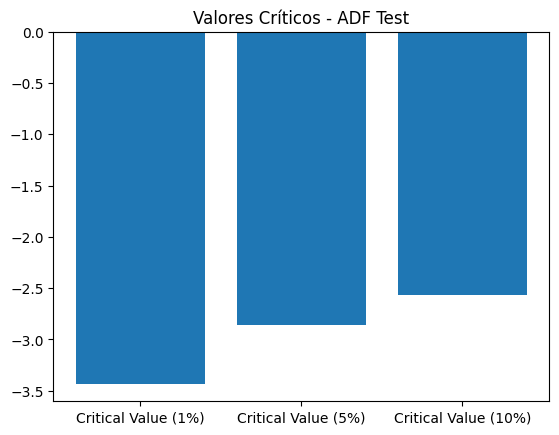

Test Statistic                   -1.616572
p-value                           0.474527
#Lags Used                        0.000000
Number of Observations Used    4342.000000
Critical Value (1%)              -3.431857
Critical Value (5%)              -2.862206
Critical Value (10%)             -2.567124
dtype: float64

In [178]:
adf_test(y_train)

* la grilla más facil me pide estar en -2,56 para que sea estacionario (y tengo 2.77)

In [179]:
y_train["oro_yj_diff"]=y_train.diff().dropna() 

In [180]:
y_dif_trans=y_train["oro_yj_diff"].dropna()

Results of Dickey-Fuller Test:


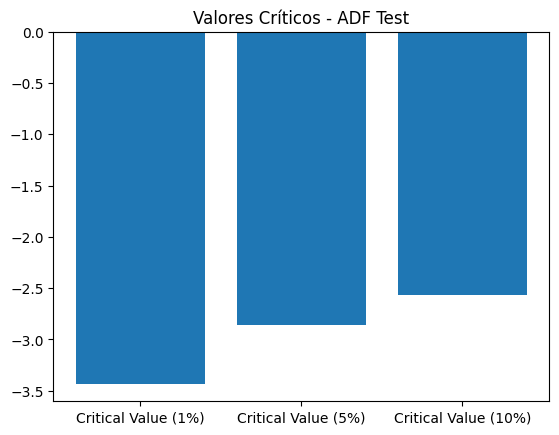

Test Statistic                  -66.039391
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    4341.000000
Critical Value (1%)              -3.431857
Critical Value (5%)              -2.862206
Critical Value (10%)             -2.567125
dtype: float64

In [181]:
adf_test(y_dif_trans)

## es estacionario

In [182]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    plt.bar(kpss_output.index[3:-1], kpss_output.values[3:-1])  
    return kpss_output

Results of KPSS Test:


C:\Users\crsar\AppData\Local\Temp\ipykernel_24256\3762776036.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Test Statistic            0.10448
p-value                   0.10000
Lags Used                14.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64

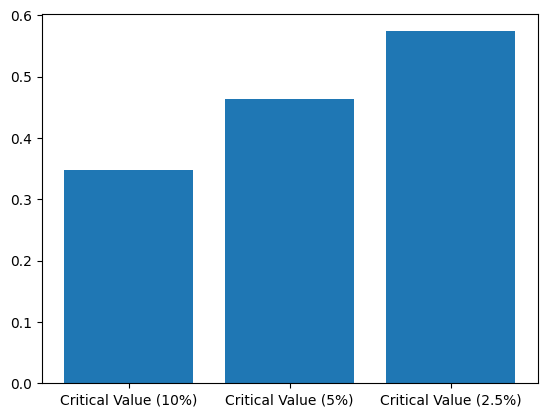

In [183]:
kpss_test(y_dif_trans)

## estacionario incluso con p value del 1%

## Analizar nuevamente la distribución

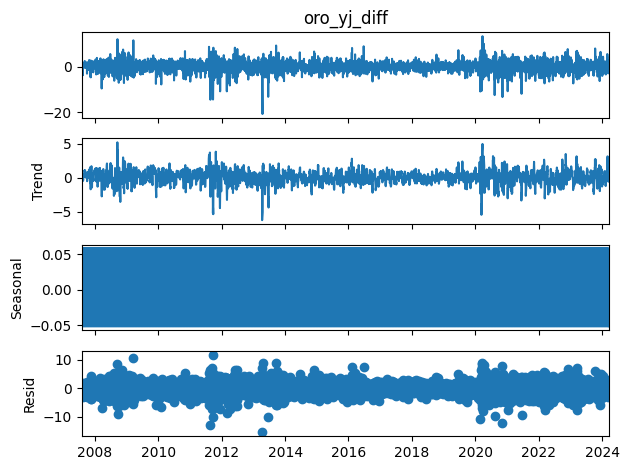

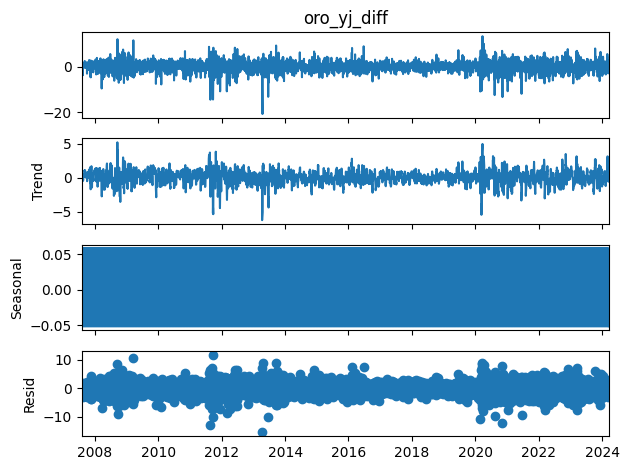

In [184]:
res_aditiva = seasonal_decompose(y_dif_trans, model="additive", period=5)  
var_add = np.nanvar(res_aditiva.resid) 
res_aditiva.plot() 

## Modelo claramente estacionario con residuos aleatoreos, sin tendencia, la serie puede ser modelada

# Construccion de hiperparametros

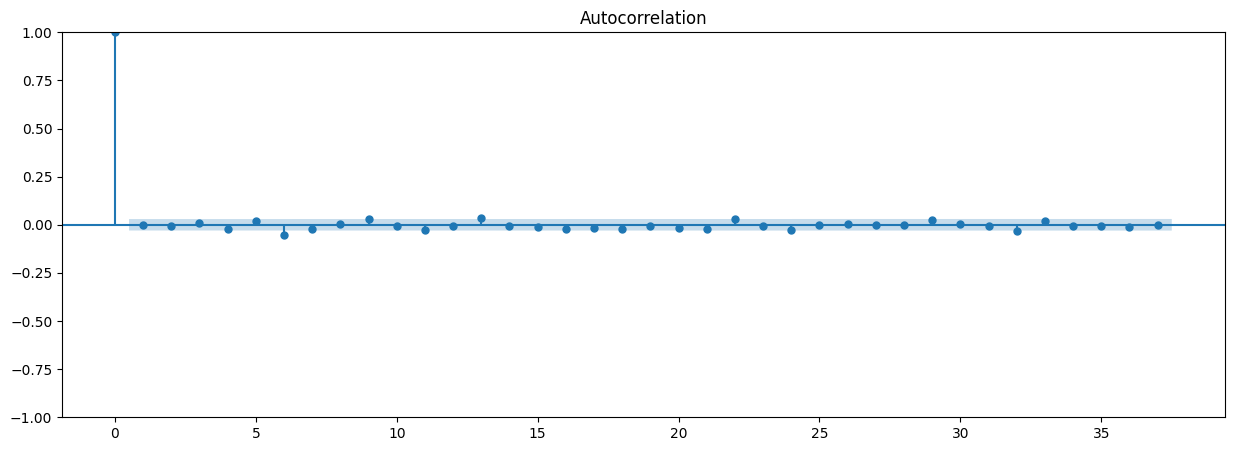

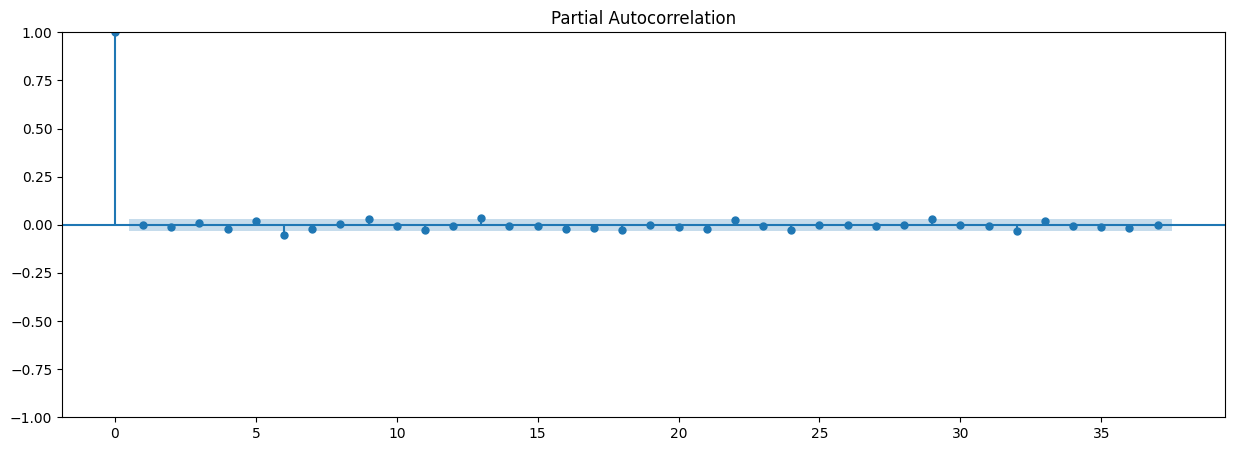

In [185]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_acf(y_dif_trans, ax=ax)
plt.show() #ACF --> ma

# PACF --> ar
fig, ax = plt.subplots(figsize=(15, 5))
plot_pacf(y_dif_trans, ax=ax)
plt.show()

##### se aprecia 1 o 2 componentes autoregresivos 
##### MA=[0,2] --> Se puede apreciar que 2 componentes pasados influyen en la media movil
##### ar=[0,2] --> no se ve ar  
##### d=1 y D=0 
##### s=5 --> serie semanal 
##### busqueda de grilla acotada entre 0 y 2, o 0 y 1

## Funcion inversa para escala original

In [186]:
def inv_yj(y_trans, lmbda):
    return np.power(y_trans * lmbda + 1, 1 / lmbda) - 1 if lmbda != 0 else np.exp(y_trans) - 1

In [187]:
df_train['oro_yj'] = yeojohnson(df_train['oro'], lmbda=lambda_opt)   
df_train['oro_yj_diff'] = df_train['oro_yj'].diff()
df_final_train = df_train.copy()

C:\Users\crsar\AppData\Local\Temp\ipykernel_24256\3079520947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['oro_yj'] = yeojohnson(df_train['oro'], lmbda=lambda_opt)
C:\Users\crsar\AppData\Local\Temp\ipykernel_24256\3079520947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['oro_yj_diff'] = df_train['oro_yj'].diff()


In [188]:
df_granger = df_final_train.copy().dropna()
target = 'oro_yj_diff'
max_lags = 10
resultados = []

print(f"Calculando ranking de variables para: {target}...")

for col in X.columns:
    try:
        # Ejecutar test (silencioso)
        test = grangercausalitytests(df_granger[[target, col]], maxlag=max_lags, verbose=False)
        
        # Buscar el mejor lag (el que tenga mayor F-Score)
        best_f = 0
        best_p = 1
        best_lag = 0
        
        for i in range(1, max_lags + 1):
            f_score = test[i][0]['ssr_ftest'][0]
            p_val   = test[i][0]['ssr_ftest'][1]
            
            if f_score > best_f:
                best_f = f_score
                best_p = p_val
                best_lag = i
        
        # Guardar resultado
        resultados.append({
            'Variable': col,
            'Mejor_Lag': best_lag,
            'F_Score': best_f,
            'P_Value': best_p
        })

    except Exception as e:
        print(f"Error en {col}: {e}")

# Crear tabla y ordenar
df_ranking = pd.DataFrame(resultados)
df_ranking = df_ranking.sort_values(by='F_Score', ascending=False).reset_index(drop=True)

# Filtrar solo las útiles (p < 0.05)
variables_utiles = df_ranking[df_ranking['P_Value'] < 0.05]['Variable'].tolist()

print("\nRanking de Importancia:")
display(df_ranking.head(10))

print("\nLista de variables:")
print(variables_utiles)

c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  

Calculando ranking de variables para: oro_yj_diff...


c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  


Ranking de Importancia:


c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,Variable,Mejor_Lag,F_Score,P_Value
0,aem,2,66.915379,2.327956e-29
1,nem,2,53.120562,1.587882e-23
2,kgc,2,51.623533,6.855435e-23
3,wpm,2,49.022339,8.724920e-22
4,paas,2,41.044001,2.172956e-18
5,ag,2,22.993910,1.161615e-10
6,tasa_5y,2,14.616161,4.709962e-07
7,tasa_10y,2,13.651256,1.228649e-06
8,fcx,2,10.309746,3.410861e-05
9,dxy_fut,2,8.670285,1.745229e-04



Lista de variables:
['aem', 'nem', 'kgc', 'wpm', 'paas', 'ag', 'tasa_5y', 'tasa_10y', 'fcx', 'dxy_fut', 'bhp', 'tasa_2y', 'desempleo_ita', 'shel', 'vix', 'emergentes', 'tsm', 'amd', 'desempleo_usa', 'unh', 'desempleo_can', 'nvda', 'xom', 'petroleo_brent', 'eqt', 'scco', 'ctra', 'spy', 'pib_gbr', 'ftse', 'sp500', 'qqq', 'dia', 'dinero_circulante_eeuu_m2_aprox_lcu', 'pib_ita', 'desempleo_mex', 'pib_fra', 'cvx', 'pib_jpn', 'pib_deu', 'pib_can', 'desempleo_ingl', 'amzn']


## Evaluación del modelo

In [189]:
#"congelaremos" el último dato manualmente 
X = df_final_train[variables_sirven].asfreq("B").ffill().bfill() 

tscv = TimeSeriesSplit(n_splits=12, test_size=10)
lmbda = lambda_opt 

all_preds_usd, all_real_usd, all_preds_yj = [], [], []
all_aic = []
all_bic = []

print("Validando SIN FUGA (Exógenas Constantes)...")

for train_idx, test_idx in tscv.split(y_yj):
    # Para entrenar, sí necesitamos shift(1) para que aprenda la relación "ayer -> hoy"
    X_train_shifted = X.iloc[train_idx].shift(1).bfill()
    
    res = SARIMAX(y_yj.iloc[train_idx], exog=X_train_shifted, 
                  order=(0, 1, 0), seasonal_order=(0, 0, 0, 0)).fit(disp=False)
    
    all_aic.append(res.aic)
    all_bic.append(res.bic)

    #ULTIMO VALOR REAL CONOCIDO
    ultimo_dato_conocido = X.iloc[train_idx].iloc[-1]
    
    #conservadora--> hoy es igual a mañana
    exog_futura = pd.DataFrame([ultimo_dato_conocido.values] * len(test_idx), 
                               index=y_yj.index[test_idx], 
                               columns=X.columns)


    fc_yj = res.forecast(steps=len(test_idx), exog=exog_futura)
    fc_usd = inv_yj(fc_yj, lmbda)
    
    all_preds_yj.extend(fc_yj)
    all_preds_usd.extend(fc_usd)
    all_real_usd.extend(y_usd.iloc[test_idx])

Validando SIN FUGA (Exógenas Constantes)...


c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [190]:
total_dias_validados = len(all_real_usd)

df_resultado = pd.DataFrame({
    'Real_USD': all_real_usd,
    'Pred_USD': all_preds_usd,
    'Pred_YJ':  all_preds_yj,
    'Error_Abs': np.abs(np.array(all_real_usd) - np.array(all_preds_usd))
}, index=y_yj.index[-total_dias_validados:])

In [191]:
all_average_aic = np.mean(all_aic) 
all_average_bic = np.mean(all_bic)

In [192]:
all_aicverage_aic

np.float64(51738.67905445255)

In [193]:
df_resultado['MAPE'] = np.abs((df_resultado['Real_USD'] - df_resultado['Pred_USD']) / df_resultado['Real_USD'].replace(0, np.nan))
df_resultado['RMSE']  = (df_resultado['Real_USD'] - df_resultado['Pred_USD']) ** 2

mape_final = df_resultado['MAPE'].mean() * 100
rmse_final = np.sqrt(df_resultado['RMSE'].mean()) 

print(f"RESULTADOS DE VALIDACIÓN (120 días), MAPE: {mape_final:.2f}%, RMSE: {rmse_final:.2f} USD")

RESULTADOS DE VALIDACIÓN (120 días), MAPE: 1.64%, RMSE: 49.53 USD


## Test de Ruido Blanco --> solo partición de entrenamiento

In [194]:
resid_concat = np.concatenate(all_resid)
lb_test = acorr_ljungbox(resid_concat, lags=[10], return_df=True)

print("\nDIAGNÓSTICO DE RESIDUOS (Test de Ljung-Box):")
display(lb_test)

p_value = lb_test["lb_pvalue"].iloc[0]

if p_value > 0.05:
    print(f"No se rechaza H0 (p={p_value:.4f} > 0.05): Los residuos son Ruido Blanco (sin autocorrelación hasta lag 10).")
    print("   El modelo capturó correctamente la estructura temporal principal.")
else:
    print(f"Se rechaza H0 (p={p_value:.4f} < 0.05): Hay autocorrelación en los residuos.")
    print("   Aún queda información temporal que el modelo no está capturando (ajustar p/q y/o estacionalidad/exógenas).")


DIAGNÓSTICO DE RESIDUOS (Test de Ljung-Box):


,lb_stat,lb_pvalue
10,22.299012,0.013652


Se rechaza H0 (p=0.0137 < 0.05): Hay autocorrelación en los residuos.
   Aún queda información temporal que el modelo no está capturando (ajustar p/q y/o estacionalidad/exógenas).


## Evaluación de Métricas de Testeo

In [ ]:
df_test_proc = df_test.asfreq("B").ffill()

# Transformación YJ (Usando el mismo lambda del train)
y_test_yj_values = yeojohnson(df_test_proc['oro'], lmbda=lambda_opt)
y_test_yj = pd.Series(y_test_yj_values, index=df_test_proc.index)

#Exógenas del Test (Asegurando mismas columnas)
X_test_proc = df_test_proc.drop(columns=['oro'], errors='ignore')
cols = X.columns  # Las columnas que seleccionaste con Granger
X_test_proc = X_test_proc[cols].asfreq("B").ffill().bfill()

# Unión Total (Train + Test)
y_total = pd.concat([y_yj, y_test_yj])
X_total = pd.concat([X, X_test_proc])

# Configuración del Split
h = 10
n_splits_test = len(y_test_yj) // h
tscv_test = TimeSeriesSplit(n_splits=n_splits_test, test_size=h)

print(f"Iniciando Validación en TEST (Sin Fuga de Información)...")
print(f"Ventanas a predecir: {n_splits_test}")
print(f"Horizonte (steps): {h} días")


preds_test_usd = []
real_test_usd = []
preds_test_yj = []
fechas_test = []

for train_idx, test_idx in tscv_test.split(y_total):
    
    if test_idx[0] < len(y_yj): 
        continue 
        
    y_train_w = y_total.iloc[train_idx]
    X_train_w = X_total.iloc[train_idx]

    X_train_shifted = X_train_w.shift(1).bfill()
    
    model = SARIMAX(y_train_w, exog=X_train_shifted,
                    order=(0, 1, 0), 
                    seasonal_order=(0, 0, 0, 0),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    res = model.fit(disp=False)

    #Congelar exógenas con el último dato conocido
    ultimo_dato_conocido = X_train_w.iloc[-1]
    
    exog_futura = pd.DataFrame([ultimo_dato_conocido.values] * len(test_idx), 
                               index=y_total.index[test_idx], 
                               columns=X_total.columns)

    fc_yj = res.forecast(steps=len(test_idx), exog=exog_futura)
    fc_usd = inv_yj(fc_yj, lmbda)

    #Real vs Predicho
    fechas_ventana = y_total.index[test_idx]
    real_val = df_test_proc.loc[fechas_ventana, 'oro']
    
    preds_test_yj.extend(fc_yj)
    preds_test_usd.extend(fc_usd)
    real_test_usd.extend(real_val)
    fechas_test.extend(fechas_ventana)

df_res_test = pd.DataFrame({
    'Real_USD': real_test_usd,
    'Pred_USD': preds_test_usd,
    'Pred_YJ': preds_test_yj,
    'Error_Abs': np.abs(np.array(real_test_usd) - np.array(preds_test_usd))
}, index=fechas_test)

Iniciando Validación en TEST (Sin Fuga de Información)...
Ventanas a predecir: 30
Horizonte (steps): 10 días


c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\crsar\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [ ]:
df_res_test['MAPE'] = np.abs((df_res_test['Real_USD'] - df_res_test['Pred_USD']) / df_res_test['Real_USD']) 
df_res_test['RMSE']  = (df_res_test['Real_USD'] - df_res_test['Pred_USD']) ** 2

In [ ]:
mape_final=df_res_test['MAPE'].mean() * 100
rmse_final=df_res_test['RMSE'].mean()

In [ ]:
print(f"RESULTADOS FINALES TEST (285 días), MAPE: {mape_final:.2f}%, RMSE: {rmse_final:.2f} USD")

RESULTADOS FINALES TEST (285 días), MAPE: 1.89%, RMSE: 6246.22 USD


In [ ]:
df_train[df_train.index == df_train.index.max()]["oro"]

FECHA
2024-09-04    2493.399902
Name: oro, dtype: float64

In [ ]:
precio_ayer_base = df_train['oro'].iloc[-1]
df_res_test['Precio_Ayer_Real'] = df_res_test['Real_USD'].shift(1).fillna(precio_ayer_base)
df_res_test['Dir_Real'] = np.sign(df_res_test['Real_USD'] - df_res_test['Precio_Ayer_Real'])
df_res_test['Dir_Pred'] = np.sign(df_res_test['Pred_USD'] - df_res_test['Precio_Ayer_Real'])

In [ ]:
df_res_test["acierto_direccion"] = df_res_test['Dir_Real'] == df_res_test['Dir_Pred']

In [ ]:
df_res_test["acierto_direccion"].value_counts()

acierto_direccion
False    155
True     145
Name: count, dtype: int64

## Plot de Test

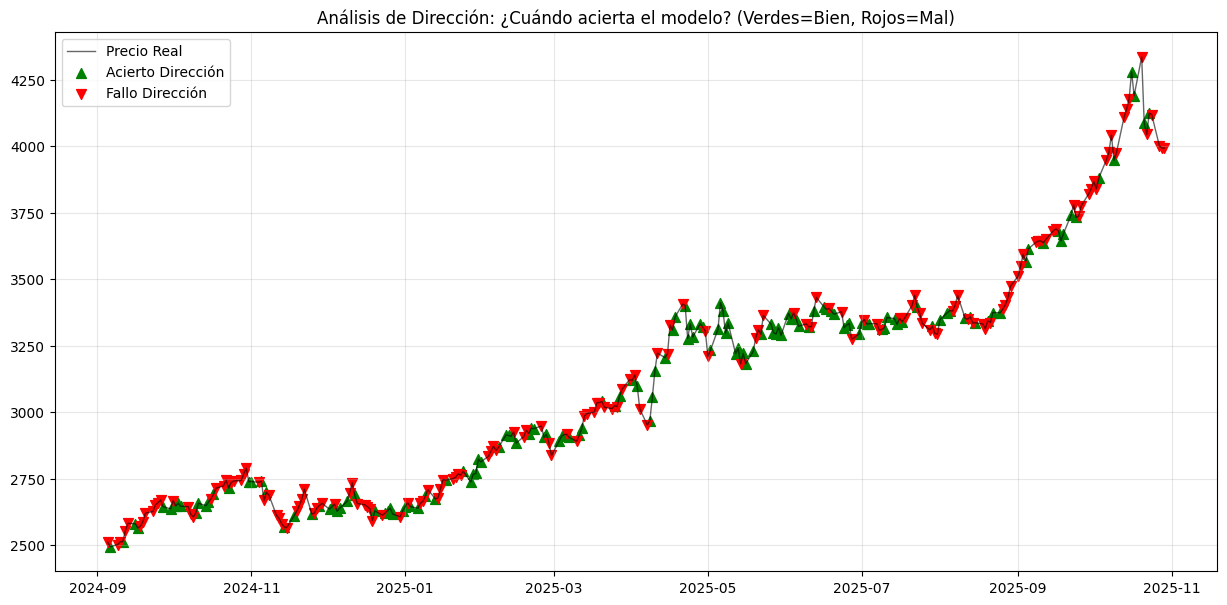

In [ ]:
aciertos = df_res_test[df_res_test['acierto_direccion'] == True]
fallos   = df_res_test[df_res_test['acierto_direccion'] == False]

plt.figure(figsize=(15, 7))

# A. Pintamos la línea del precio Real
plt.plot(df_res_test.index, df_res_test['Real_USD'], label='Precio Real', color='black', alpha=0.6, linewidth=1)

# B. Pintamos los Puntos Verdes (Aciertos)
plt.scatter(aciertos.index, aciertos['Real_USD'], color='green', label='Acierto Dirección', marker='^', s=50)

# C. Pintamos los Puntos Rojos (Fallos)
plt.scatter(fallos.index, fallos['Real_USD'], color='red', label='Fallo Dirección', marker='v', s=50)

plt.title(f'Análisis de Dirección: --> Verdes=Bien, Rojos=Mal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

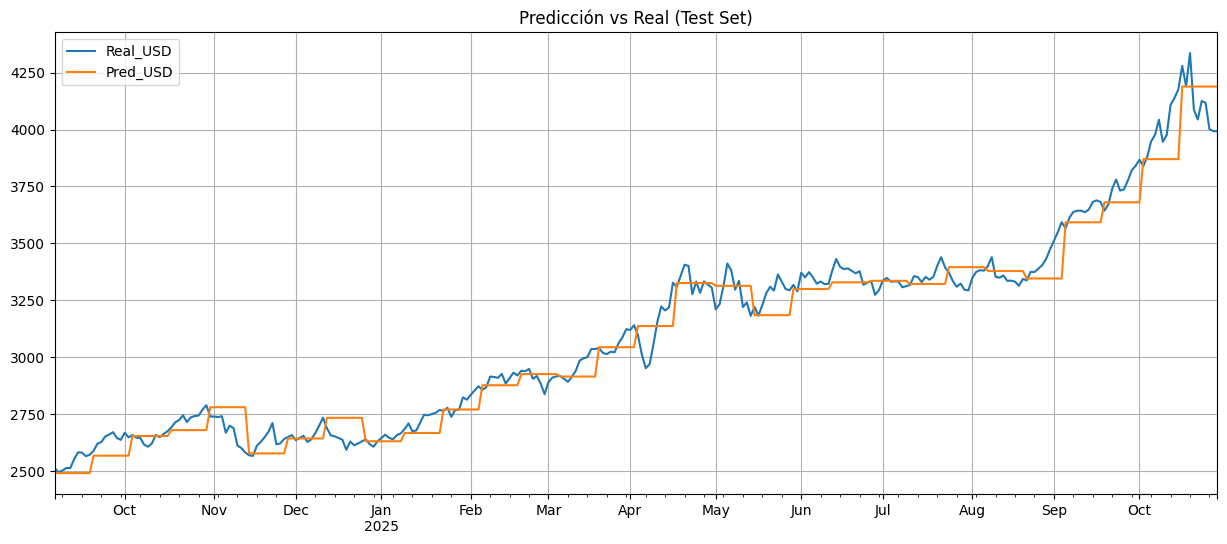

In [ ]:
df_res_test[['Real_USD', 'Pred_USD']].plot(figsize=(15, 6), title="Predicción vs Real (Test Set)", grid=True)
plt.show()